In [ ]:
import os # Allows us to access dataset that we loaded
import pandas as pd # Data manipulation library
import numpy as np  # Allows us to use numerical computing
import matplotlib.pyplot as plt  # Allows us to visualize data
import seaborn as sns # Allows us to create advanced visualizations

In [ ]:
# ! means command line; masoudnickparvar is the kaggle username
! kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset --unzip

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
 99% 147M/149M [00:01<00:00, 126MB/s]
100% 149M/149M [00:01<00:00, 133MB/s]


In [ ]:
from genericpath import isdir
def get_class_paths(path):
  classes = []
  class_paths = []

  # Iterate through directories in the training path
  for label in os.listdir(path):
    label_path = os.path.join(path, label)

    # Check if it's a directory
    if os.path.isdir(label_path):
      # Iterate through images in the label directory
      for image in os.listdir(label_path):
        image_path = os.path.join(label_path, image)

        # Add class and path to respective lists
        classes.append(label)
        class_paths.append(image_path)

  # Create a DataFrame with the collected data
  df = pd.DataFrame({
      'Class Path': class_paths,
      'Class': classes
  })

  return df

In [ ]:
tr_df = get_class_paths("/content/Training")

In [ ]:
tr_df

,Class Path,Class
0,/content/Training/notumor/Tr-no_0794.jpg,notumor
1,/content/Training/notumor/Tr-no_1039.jpg,notumor
2,/content/Training/notumor/Tr-no_0972.jpg,notumor
3,/content/Training/notumor/Tr-no_0559.jpg,notumor
4,/content/Training/notumor/Tr-no_1252.jpg,notumor
...,...,...
5707,/content/Training/glioma/Tr-gl_0255.jpg,glioma
5708,/content/Training/glioma/Tr-gl_0182.jpg,glioma
5709,/content/Training/glioma/Tr-gl_0553.jpg,glioma
5710,/content/Training/glioma/Tr-gl_0380.jpg,glioma


In [ ]:
ts_df = get_class_paths("/content/Testing")

In [ ]:
ts_df

,Class Path,Class
0,/content/Testing/notumor/Te-no_0097.jpg,notumor
1,/content/Testing/notumor/Te-no_0301.jpg,notumor
2,/content/Testing/notumor/Te-noTr_0000.jpg,notumor
3,/content/Testing/notumor/Te-no_0222.jpg,notumor
4,/content/Testing/notumor/Te-no_0139.jpg,notumor
...,...,...
1306,/content/Testing/glioma/Te-gl_0280.jpg,glioma
1307,/content/Testing/glioma/Te-gl_0163.jpg,glioma
1308,/content/Testing/glioma/Te-gl_0194.jpg,glioma
1309,/content/Testing/glioma/Te-gl_0146.jpg,glioma


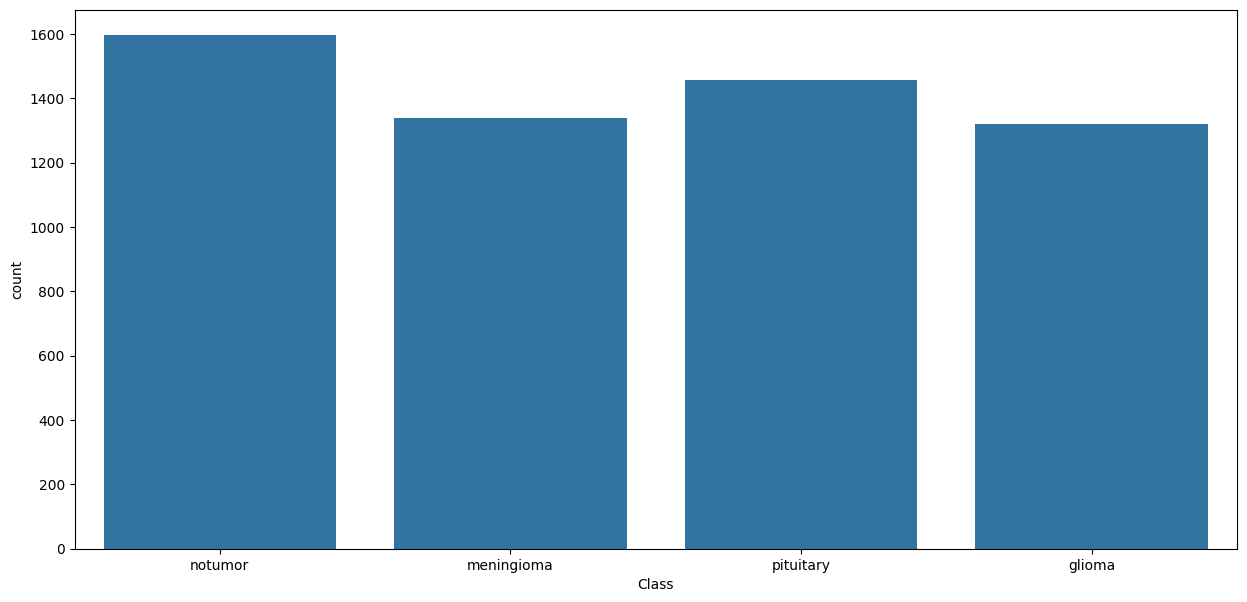

In [ ]:
plt.figure(figsize=(15, 7))
ax = sns.countplot(data=tr_df, x=tr_df['Class'])

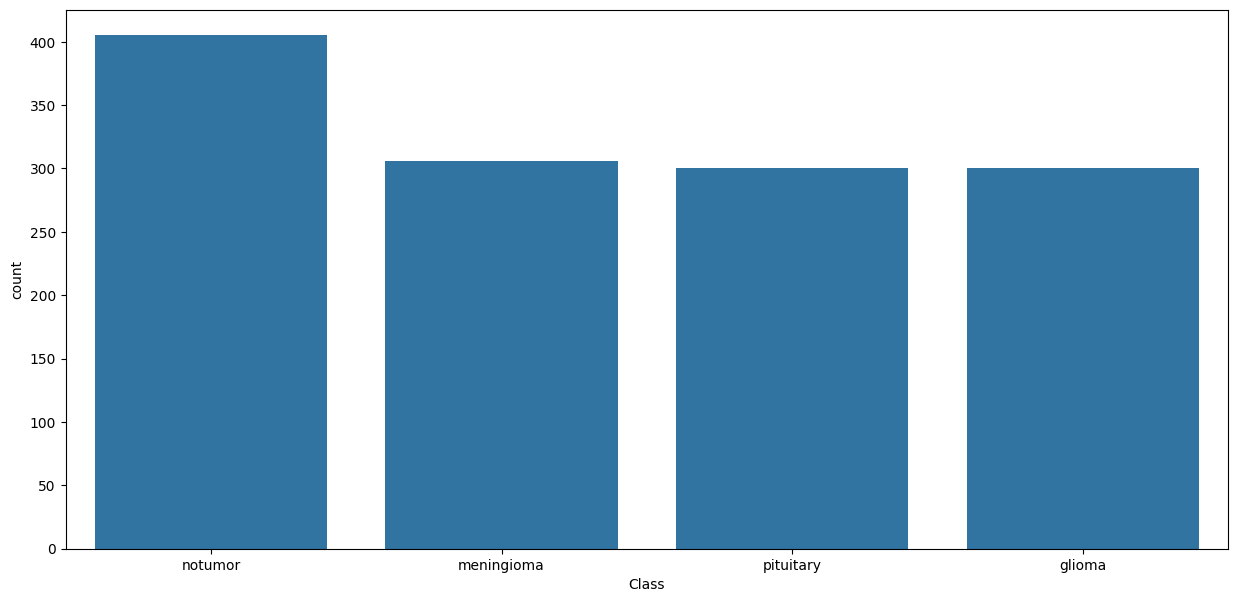

In [ ]:
plt.figure(figsize=(15, 7))
ax = sns.countplot(data=ts_df, x=ts_df['Class'])

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf

# Allows us to build neural network model layer by layer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Splits testing data into validation and testing set
# Helps tune the model and prevent overfitting

valid_df, ts_df = train_test_split(ts_df, test_size=0.5, stratify=ts_df['Class'])

In [ ]:
valid_df

,Class Path,Class
822,/content/Testing/pituitary/Te-pi_0271.jpg,pituitary
1004,/content/Testing/pituitary/Te-pi_0163.jpg,pituitary
116,/content/Testing/notumor/Te-no_0378.jpg,notumor
483,/content/Testing/meningioma/Te-me_0225.jpg,meningioma
161,/content/Testing/notumor/Te-no_0116.jpg,notumor
...,...,...
745,/content/Testing/pituitary/Te-pi_0140.jpg,pituitary
1074,/content/Testing/glioma/Te-gl_0099.jpg,glioma
523,/content/Testing/meningioma/Te-me_0147.jpg,meningioma
891,/content/Testing/pituitary/Te-pi_0299.jpg,pituitary


In [ ]:
ts_df

,Class Path,Class
848,/content/Testing/pituitary/Te-pi_0095.jpg,pituitary
990,/content/Testing/pituitary/Te-pi_0236.jpg,pituitary
89,/content/Testing/notumor/Te-no_0190.jpg,notumor
79,/content/Testing/notumor/Te-no_0398.jpg,notumor
917,/content/Testing/pituitary/Te-piTr_0003.jpg,pituitary
...,...,...
961,/content/Testing/pituitary/Te-pi_0162.jpg,pituitary
188,/content/Testing/notumor/Te-no_0218.jpg,notumor
853,/content/Testing/pituitary/Te-pi_0150.jpg,pituitary
826,/content/Testing/pituitary/Te-pi_0084.jpg,pituitary


In [ ]:
# Pre-process data by rescaling images and adjusting brightness

# Number of images model will process at once (command sizes are 16, 32, 64, 128)
batch_size = 16

# Rescales pixels from 0-255 to 0-1 and randomly adjusts brightness of images
img_size = (299, 299)
image_generator = ImageDataGenerator(rescale=1/255, brightness_range=(0.8, 1.2))

# Testing images are rescaled but brightness is not adjusted
ts_gen = ImageDataGenerator(rescale=1/255)

In [ ]:
# Takes training data frame and resizes them to prepare them for the model
tr_gen = image_generator.flow_from_dataframe(tr_df,
                                             x_col='Class Path',
                                             y_col='Class',
                                             batch_size=batch_size,
                                             target_size=img_size)

valid_gen = image_generator.flow_from_dataframe(valid_df,
                                                x_col='Class Path',
                                                y_col='Class',
                                                batch_size=batch_size,
                                                target_size=img_size)

ts_gen = ts_gen.flow_from_dataframe(ts_df,
                                    x_col='Class Path',
                                    y_col='Class',
                                    batch_size=16,
                                    target_size=img_size,
                                    shuffle=False)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


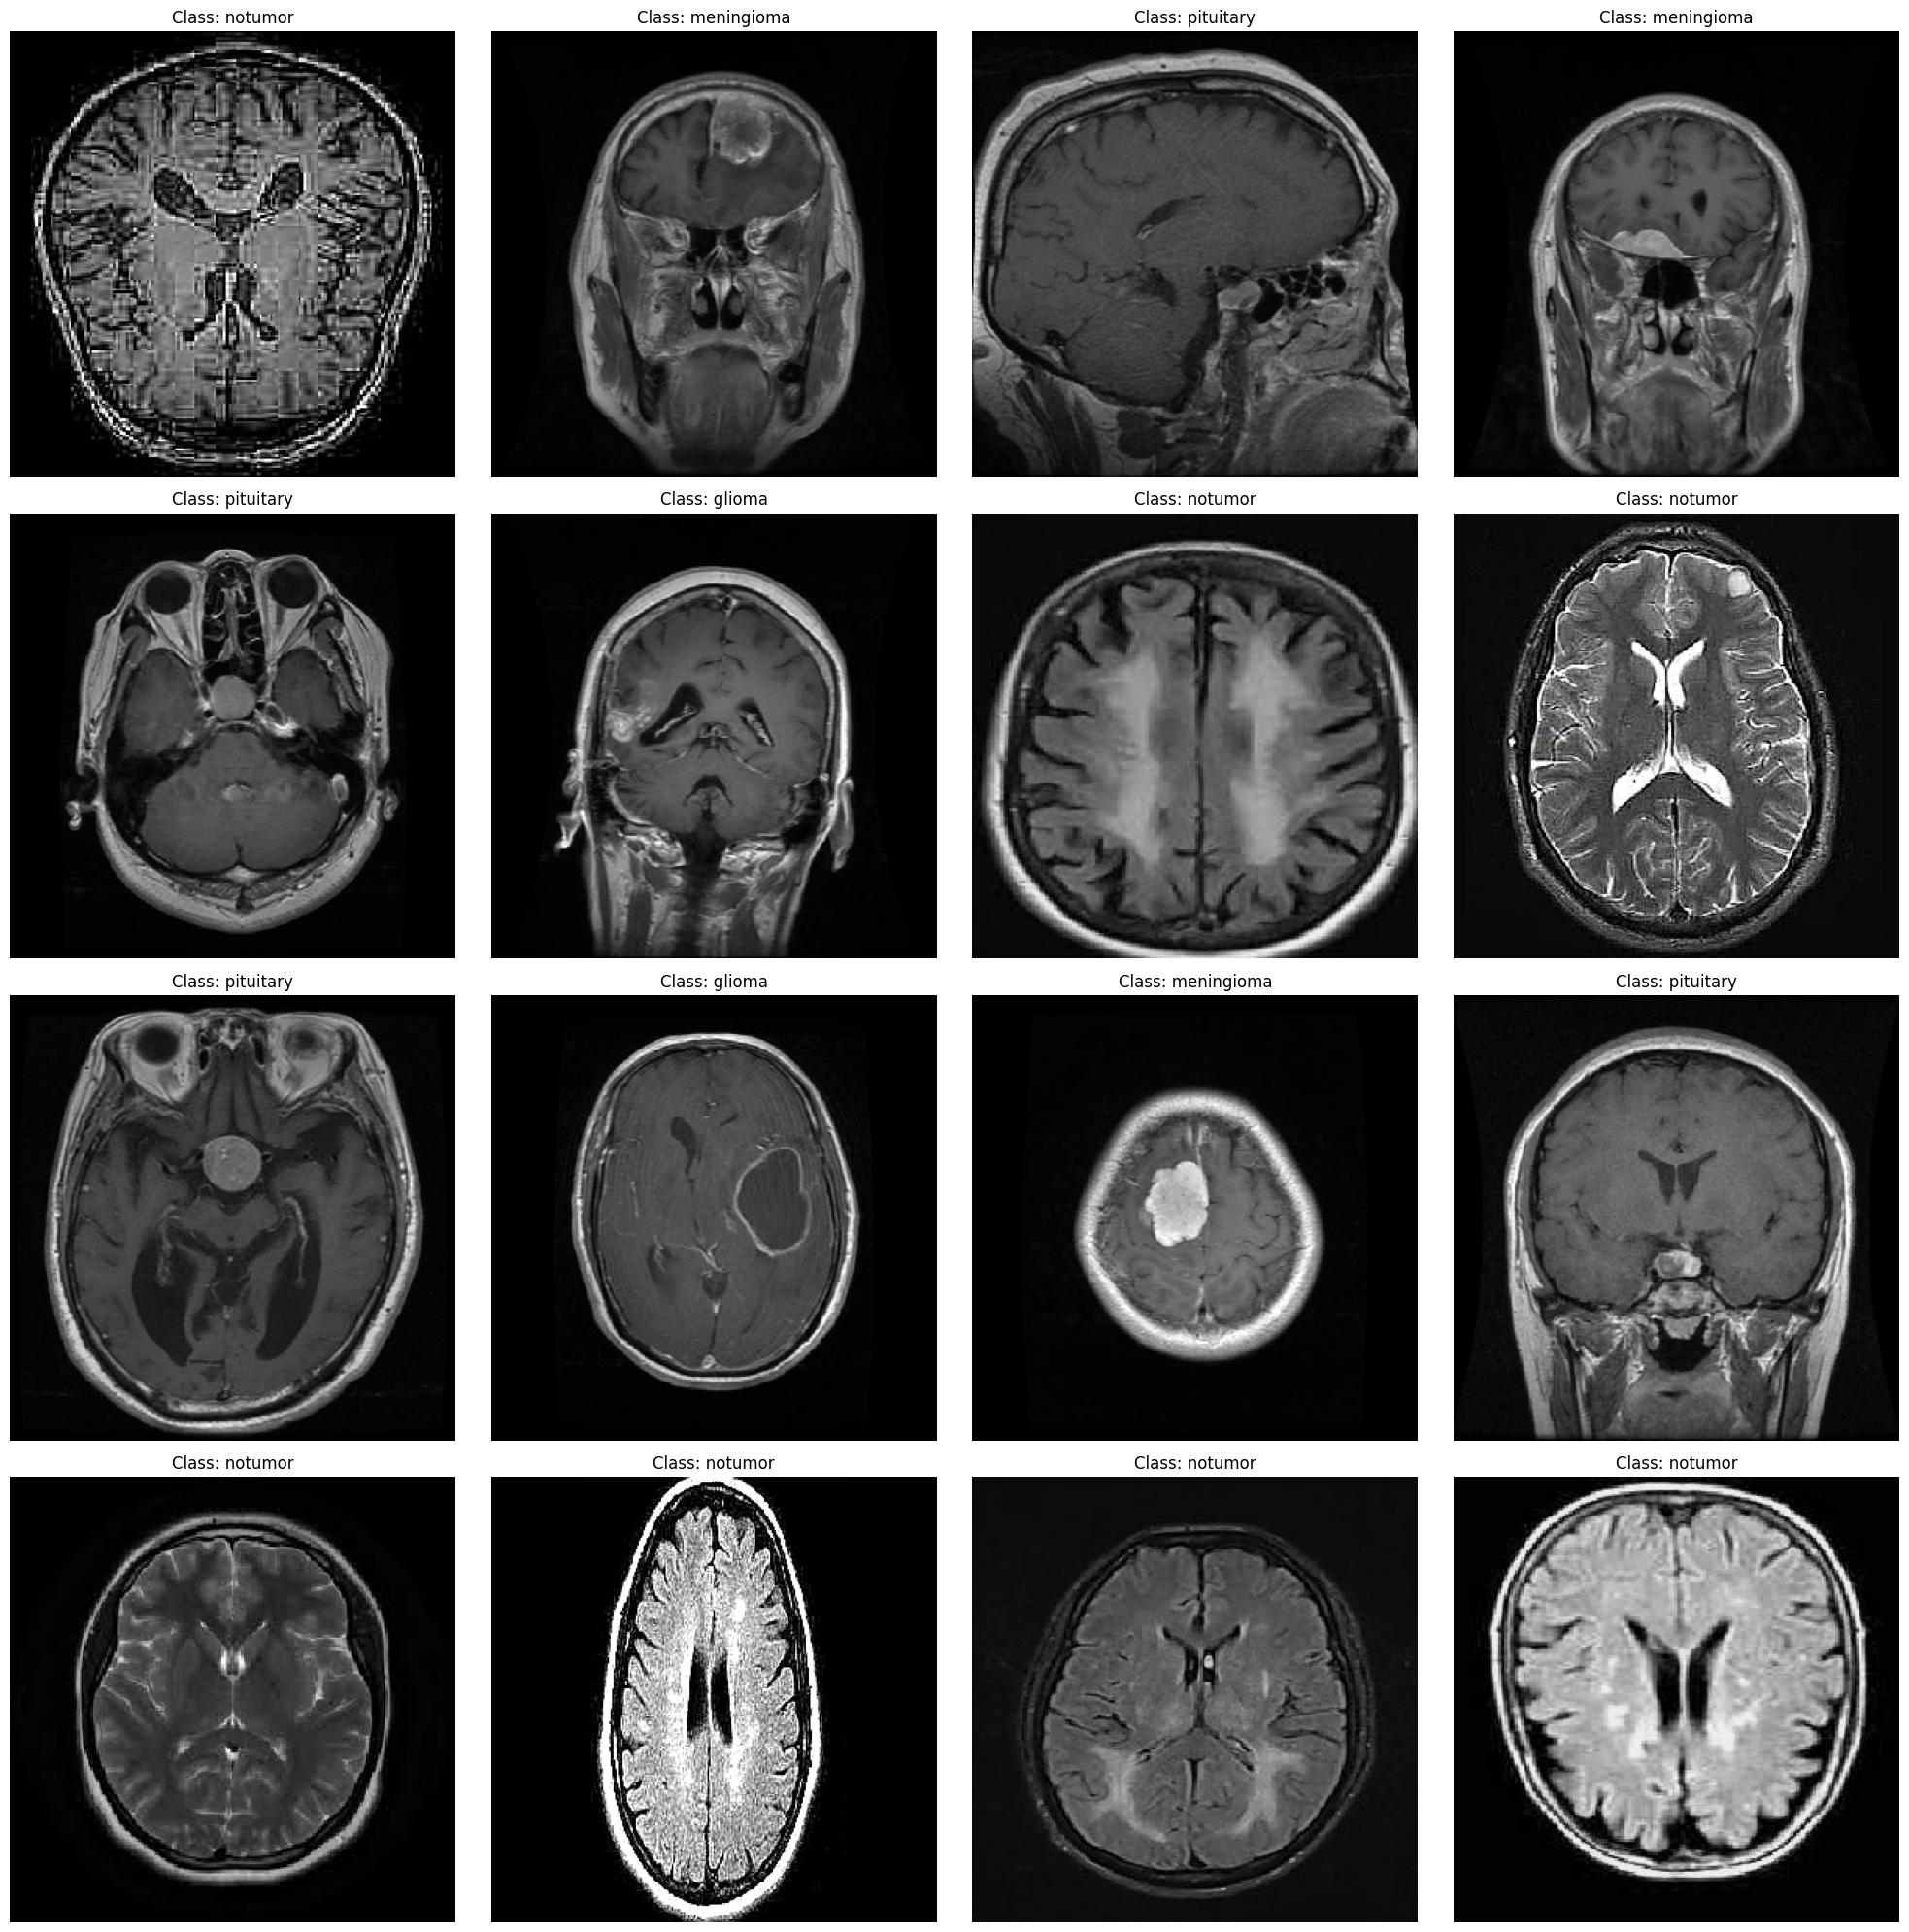

In [ ]:
plt.figure(figsize=(20, 20))
for i in range(16):
  plt.subplot(4, 4, i+1)
  batch = next(tr_gen)
  image = batch [0] [0]
  label = batch [1] [0]
  plt.imshow(image)

  # Get the class index
  class_index = np.argmax(label)

  # Get the list of class names and class indices
  class_names = list(tr_gen.class_indices.keys())
  class_indices = list(tr_gen.class_indices.values())

  # Find the index of the class_index in the list of indices
  index_position = class_indices.index(class_index)

  # Get the class name using the index position
  class_name = class_names [index_position]

  plt.title(f"Class: {class_name}")
  plt.axis('off')
plt.tight_layout ()
plt.show()

In [ ]:
# images are 299x299 with 3 colors (RGB)
img_shape = (299, 299, 3)

base_model = tf.keras.applications.Xception(include_top=False,
                                            weights="imagenet",
                                            input_shape=img_shape,
                                            pooling='max')

model = Sequential([
    base_model,
    Flatten(),
    Dropout(rate=0.3),
    Dense(128, activation='relu'),
    Dropout(rate=0.25),
    Dense(4, activation='softmax')
])

In [ ]:
model.compile(Adamax(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy',
              Precision(),
              Recall()])

In [ ]:
hist = model.fit(tr_gen, epochs=5, validation_data=valid_gen)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


357/357 ━━━━━━━━━━━━━━━━━━━━ 225s 465ms/step - accuracy: 0.8058 - loss: 0.5872 - precision: 0.8546 - recall: 0.7242 - val_accuracy: 0.9496 - val_loss: 0.1352 - val_precision: 0.9626 - val_recall: 0.9420
Epoch 2/5
357/357 ━━━━━━━━━━━━━━━━━━━━ 212s 431ms/step - accuracy: 0.9747 - loss: 0.0744 - precision: 0.9764 - recall: 0.9728 - val_accuracy: 0.9771 - val_loss: 0.0778 - val_precision: 0.9771 - val_recall: 0.9771
Epoch 3/5
357/357 ━━━━━━━━━━━━━━━━━━━━ 154s 429ms/step - accuracy: 0.9893 - loss: 0.0386 - precision: 0.9897 - recall: 0.9892 - val_accuracy: 0.9802 - val_loss: 0.1091 - val_precision: 0.9802 - val_recall: 0.9802
Epoch 4/5
357/357 ━━━━━━━━━━━━━━━━━━━━ 153s 428ms/step - accuracy: 0.9942 - loss: 0.0227 - precision: 0.9945 - recall: 0.9941 - val_accuracy: 0.9878 - val_loss: 0.1024 - val_precision: 0.9878 - val_recall: 0.9878
Epoch 5/5
357/357 ━━━━━━━━━━━━━━━━━━━━ 154s 430ms/step - accuracy: 0.9972 - loss: 0.0093 - precision: 0.9976 - recall: 0.9971 - val_accuracy: 0.9878 - val_los

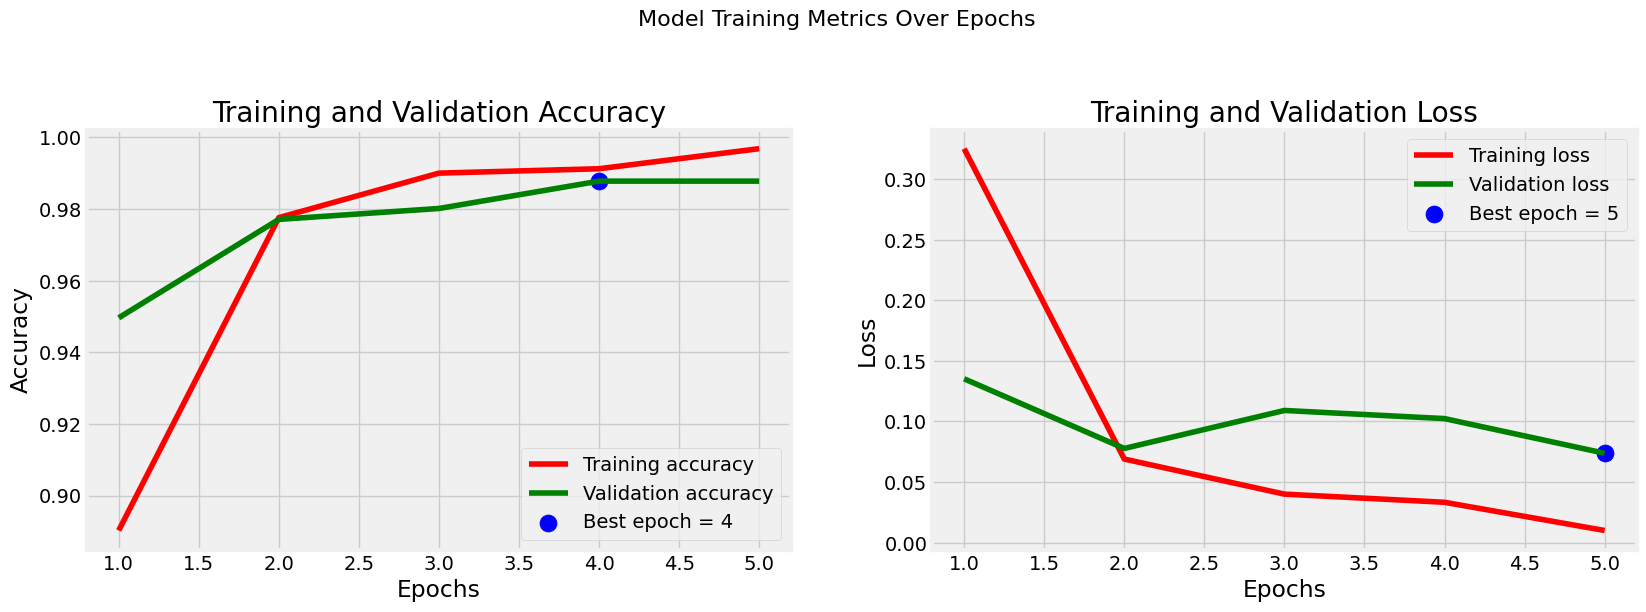

In [ ]:
# Get training and validation metrics from history
metrics = ['accuracy', 'loss']
tr_metrics = {m: hist.history[m] for m in metrics}
val_metrics = {m: hist.history[f'val_{m}'] for m in metrics}

# Find best epochs and values
best_epochs = {}
best_values = {}
for m in metrics:
  if m == 'loss':
    idx = np.argmin(val_metrics[m])
  else:
    idx = np.argmax(val_metrics[m])
  best_epochs[m] = idx + 1
  best_values[m] = val_metrics[m][idx]

# Plot metrics
plt.figure(figsize=(20, 12))
plt.style.use('fivethirtyeight')

for i, metric in enumerate(metrics, 1):
  plt.subplot(2, 2, i)
  epochs = range(1, len(tr_metrics [metric]) + 1)

  plt.plot(epochs, tr_metrics[metric], 'r', label=f'Training {metric}')
  plt.plot(epochs, val_metrics[metric], 'g', label=f'Validation {metric}')
  plt.scatter(best_epochs[metric], best_values[metric], s=150, c='blue',
  label=f'Best epoch = {best_epochs[metric] }')

  plt.title(f'Training and Validation {metric.title()}')
  plt.xlabel('Epochs')
  plt.ylabel(metric.title())
  plt. legend()
  plt.grid(True)

plt.suptitle('Model Training Metrics Over Epochs', fontsize=16)
plt. show()

In [ ]:
train_score = model.evaluate(tr_gen, verbose=1)
valid_score = model.evaluate(valid_gen, verbose=1)
test_score = model.evaluate(ts_gen, verbose=1)

print(f"Train Accuracy: {train_score[1]*100:.2f}%")
print(f"Train Loss: {train_score[0]:.4f}")
print(f"\n\nValidation Accuracy: {valid_score[1]*100:.2f}%")
print(f"Validation Loss: {valid_score[0]:.4f}")
print(f"\n\nTest Accuracy: {test_score[1]*100:.2f}%")
print(f"Test Loss: {test_score[0]:.4f}")

357/357 ━━━━━━━━━━━━━━━━━━━━ 43s 121ms/step - accuracy: 0.9995 - loss: 0.0019 - precision: 0.9995 - recall: 0.9995
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 0.9885 - loss: 0.0846 - precision: 0.9885 - recall: 0.9879
 1/41 ━━━━━━━━━━━━━━━━━━━━ 6s 157ms/step - accuracy: 1.0000 - loss: 2.5108e-04 - precision: 1.0000 - recall: 1.0000

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - accuracy: 0.9989 - loss: 0.0098 - precision: 0.9989 - recall: 0.9989
Train Accuracy: 99.95%
Train Loss: 0.0021


Validation Accuracy: 99.08%
Validation Loss: 0.0711


Test Accuracy: 99.70%
Test Loss: 0.0329


41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 106ms/step


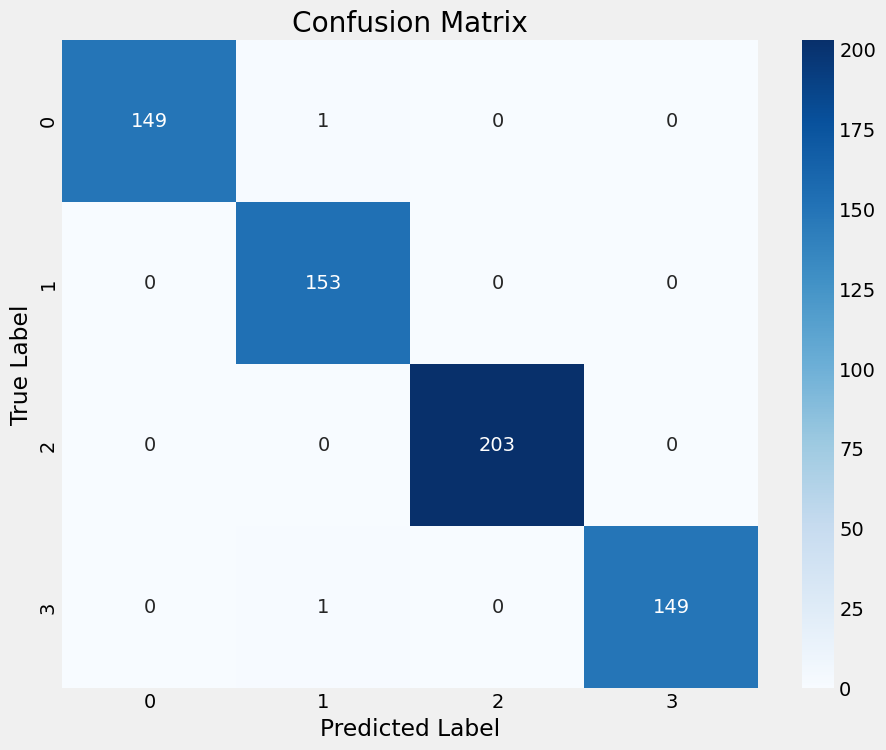

In [ ]:
# Asking trained model to make predictions based on test dataset
preds = model.predict(ts_gen)
y_pred = np.argmax(preds, axis=1)

class_dict = {
    0: 'glioma',
    1: 'meningioma',
    2: 'no_tumor',
    3: 'pituitary'
}

# Then create and display the confusion matrix
cm = confusion_matrix(ts_gen.classes, y_pred)
labels = list(class_dict.keys())
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from PIL import Image

def predict(img_path: str) -> None:
  # Get class labels
  labels = list(class_dict.keys())

  # Create figure
  plt.figure(figsize=(6,8))

  # Load and preprocess image
  img = Image.open(img_path)
  resized_img = img.resize((299, 299))
  img_array = np.asarray(resized_img)
  img_array = np.expand_dims(img_array, axis=0) / 255.0

  # Get model predictions
  predictions = model.predict(img_array)
  probabilities = list(predictions[0])

  # Get predicted class
  predicted_class_idx = np.argmax(probabilities)
  predicted_class = class_dict[predicted_class_idx]

  # Plot original image
  plt.subplot(2, 1, 1)
  plt.imshow(resized_img)
  plt.title(f"Input MRI Image\nPredicted: {predicted_class}")

  # Plot prediction probabilities
  plt.subplot(2, 1, 2)
  bars = plt.barh(labels, probabilities)
  plt.xlabel("Probability", fontsize=15)
  plt.title("Class Probabilities")

  # Add probability labels to bars
  ax = plt.gca()
  ax.bar_label(bars, fmt="%.2f")

  plt.tight_layout()
  plt.show()

  print(f"\nPredicted tumor type: {predicted_class}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


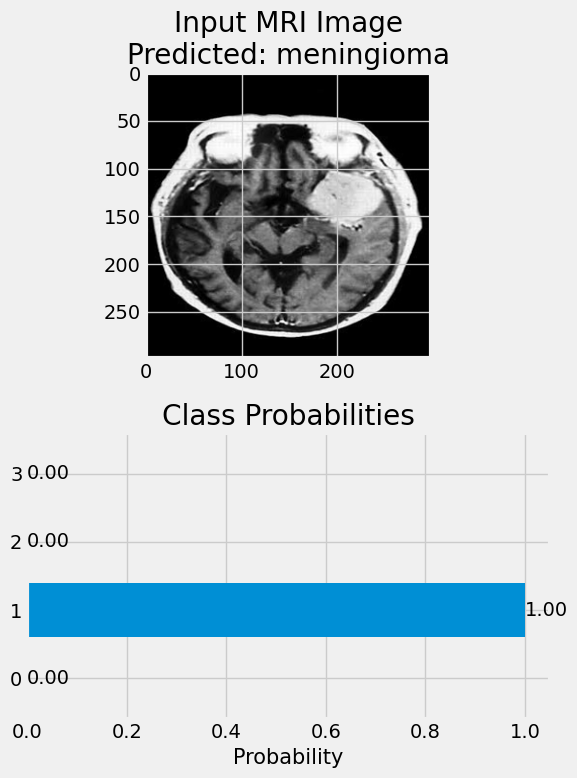


Predicted tumor type: meningioma


In [ ]:
predict("/content/Testing/meningioma/Te-meTr_0005.jpg")

In [ ]:
model.save_weights("xception_model.weights.h5")

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers

In [ ]:
# Copied code from above

# Number of images model will process at once (command sizes are 16, 32, 64, 128)
batch_size = 16

# Rescales pixels from 0-255 to 0-1 and randomly adjusts brightness of images
img_size = (224, 224)

image_generator = ImageDataGenerator(rescale=1/255, brightness_range=(0.8, 1.2))

# Testing images are rescaled but brightness is not adjusted
ts_gen = ImageDataGenerator(rescale=1/255)

# Takes training data frame and resizes them to prepare them for the model
tr_gen = image_generator.flow_from_dataframe(tr_df,
                                             x_col='Class Path',
                                             y_col='Class',
                                             batch_size=batch_size,
                                             target_size=img_size)

valid_gen = image_generator.flow_from_dataframe(valid_df,
                                                x_col='Class Path',
                                                y_col='Class',
                                                batch_size=batch_size,
                                                target_size=img_size)

ts_gen = ts_gen.flow_from_dataframe(ts_df,
                                    x_col='Class Path',
                                    y_col='Class',
                                    batch_size=16,
                                    target_size=img_size,
                                    shuffle=False)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


In [ ]:
cnn_model = Sequential()

# Convolutional layers
cnn_model.add(Conv2D(512, (3, 3), padding='same', input_shape=(224, 224, 3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

cnn_model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.25))

cnn_model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.25))

cnn_model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the output for fully connected layers
cnn_model.add(Flatten())

# Fully connected layers
cnn_model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
cnn_model.add(Dropout(0.35))

cnn_model.add(Dense(4, activation='softmax'))

# Compile the model
cnn_model.compile(Adamax(learning_rate = 0.001), loss='categorical_crossentropy', metrics=['accuracy', Precision(), Recall()])

# Display the model summary
cnn_model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 224, 224, 512)       │          14,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 512)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 112, 112, 256)       │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 56, 56, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 56, 56, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 28, 28, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │       3,211,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,775,620 (18.22 MB)

 Trainable params: 4,775,620 (18.22 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = cnn_model.fit(tr_gen, epochs=5, validation_data=valid_gen)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


357/357 ━━━━━━━━━━━━━━━━━━━━ 157s 361ms/step - accuracy: 0.5748 - loss: 2.1885 - precision_1: 0.6999 - recall_1: 0.3925 - val_accuracy: 0.7771 - val_loss: 0.8121 - val_precision_1: 0.8156 - val_recall_1: 0.7359
Epoch 2/5
357/357 ━━━━━━━━━━━━━━━━━━━━ 154s 297ms/step - accuracy: 0.8213 - loss: 0.6794 - precision_1: 0.8409 - recall_1: 0.7865 - val_accuracy: 0.8137 - val_loss: 0.6314 - val_precision_1: 0.8165 - val_recall_1: 0.7878
Epoch 3/5
357/357 ━━━━━━━━━━━━━━━━━━━━ 107s 297ms/step - accuracy: 0.8617 - loss: 0.5243 - precision_1: 0.8764 - recall_1: 0.8481 - val_accuracy: 0.8626 - val_loss: 0.5007 - val_precision_1: 0.8732 - val_recall_1: 0.8305
Epoch 4/5
357/357 ━━━━━━━━━━━━━━━━━━━━ 144s 304ms/step - accuracy: 0.8938 - loss: 0.4398 - precision_1: 0.9056 - recall_1: 0.8824 - val_accuracy: 0.8687 - val_loss: 0.4437 - val_precision_1: 0.8744 - val_recall_1: 0.8611
Epoch 5/5
357/357 ━━━━━━━━━━━━━━━━━━━━ 107s 298ms/step - accuracy: 0.9212 - loss: 0.3520 - precision_1: 0.9257 - recall_1: 0.9

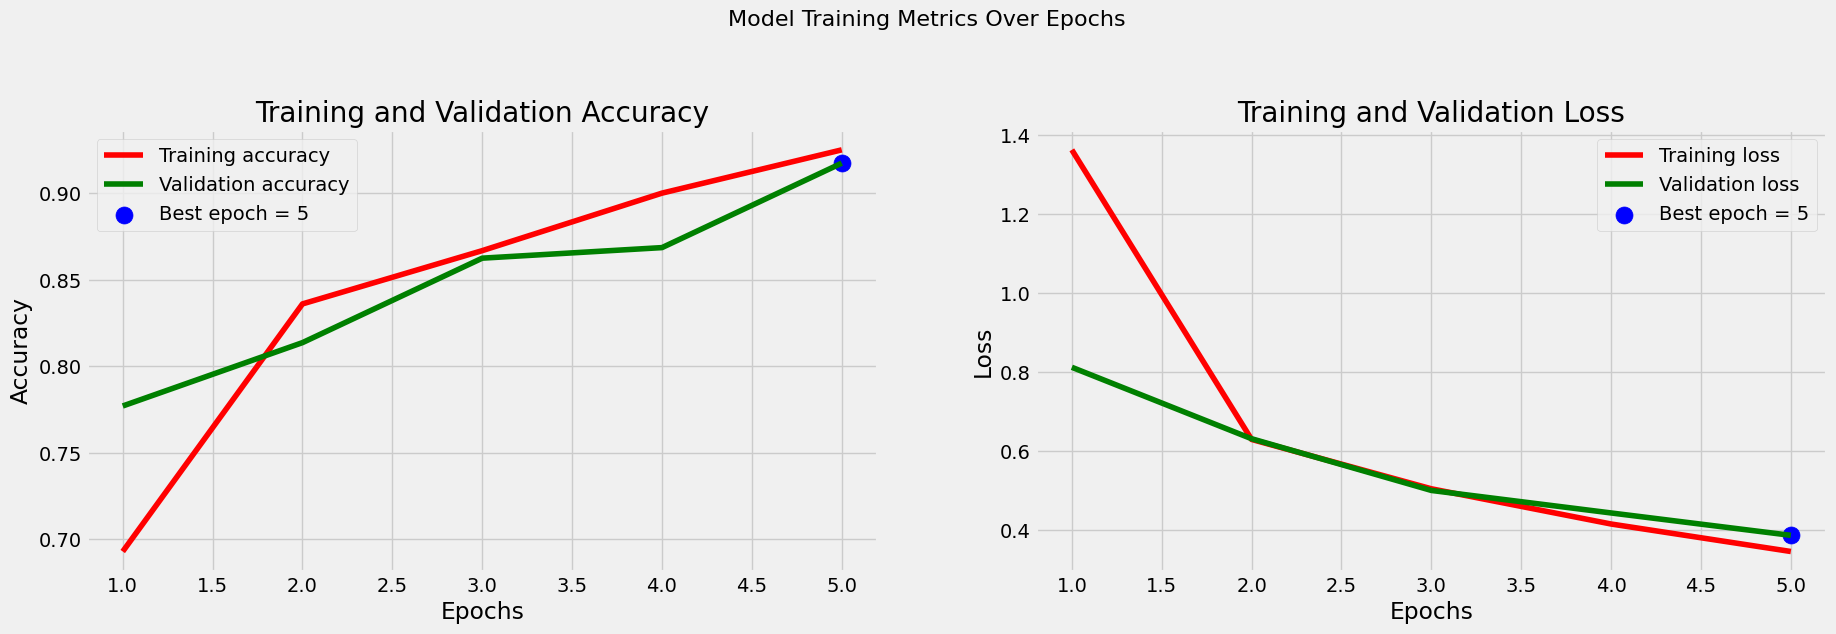

In [ ]:
# Get training and validation metrics from history
metrics = ['accuracy', 'loss']
tr_metrics = {m: history.history[m] for m in metrics}
val_metrics = {m: history.history[f'val_{m}'] for m in metrics}

# Find best epochs and values
best_epochs = {}
best_values = {}
for m in metrics:
  if m == 'loss':
    idx = np.argmin(val_metrics[m])
  else:
    idx = np.argmax(val_metrics[m])
  best_epochs[m] = idx + 1
  best_values[m] = val_metrics[m][idx]

# Plot metrics
plt.figure(figsize=(20, 12))
plt.style.use('fivethirtyeight')

for i, metric in enumerate(metrics, 1):
  plt.subplot(2, 2, i)
  epochs = range(1, len(tr_metrics [metric]) + 1)

  plt.plot(epochs, tr_metrics[metric], 'r', label=f'Training {metric}')
  plt.plot(epochs, val_metrics[metric], 'g', label=f'Validation {metric}')
  plt.scatter(best_epochs[metric], best_values[metric], s=150, c='blue',
  label=f'Best epoch = {best_epochs[metric] }')

  plt.title(f'Training and Validation {metric.title()}')
  plt.xlabel('Epochs')
  plt.ylabel(metric.title())
  plt. legend()
  plt.grid(True)

plt.suptitle('Model Training Metrics Over Epochs', fontsize=16)
plt. show()

In [ ]:
train_score = cnn_model.evaluate(tr_gen, verbose=1)
valid_score = cnn_model.evaluate(valid_gen, verbose=1)
test_score = cnn_model.evaluate(ts_gen, verbose=1)

print(f"Train Accuracy: {train_score[1]*100:.2f}%")
print(f"Train Loss: {train_score[0]:.4f}")
print(f"\n\nValidation Accuracy: {valid_score[1]*100:.2f}%")
print(f"Validation Loss: {valid_score[0]:.4f}")
print(f"\n\nTest Accuracy: {test_score[1]*100:.2f}%")
print(f"Test Loss: {test_score[0]:.4f}")

357/357 ━━━━━━━━━━━━━━━━━━━━ 29s 80ms/step - accuracy: 0.9589 - loss: 0.2661 - precision_1: 0.9615 - recall_1: 0.9551
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - accuracy: 0.9008 - loss: 0.4186 - precision_1: 0.9073 - recall_1: 0.8926
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - accuracy: 0.9102 - loss: 0.3715 - precision_1: 0.9124 - recall_1: 0.9084
Train Accuracy: 96.25%
Train Loss: 0.2587


Validation Accuracy: 92.06%
Validation Loss: 0.3854


Test Accuracy: 90.40%
Test Loss: 0.3746


In [ ]:
# Asking trained model to make predictions based on test dataset
preds = cnn_model.predict(ts_gen)
y_pred = np.argmax(preds, axis=1)

class_dict = {
    0: 'glioma',
    1: 'meningioma',
    2: 'no_tumor',
    3: 'pituitary'
}

# Then create and display the confusion matrix
cm = confusion_matrix(ts_gen.classes, y_pred)
labels = list(class_dict.keys())
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
clr = classification_report(ts_gen.classes, y_pred)
print(clr)

In [ ]:
cnn_model.save("cnn_model.h5")

In [ ]:
!pip install streamlit pyngrok python-dotenv

In [ ]:
from threading import Thread
from pyngrok import ngrok
from google.colab import userdata

In [ ]:
ngrok_token = userdata.get('NGROK_AUTH_TOKEN')

ngrok.set_auth_token(ngrok_token)

In [ ]:
def run_streamlit():
  os.system("streamlit run /content/app.py --server.port 8501")

In [ ]:
%%writefile app.py

import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import streamlit as st
import plotly.graph_objects as go
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
import google.generativeai as genai
from google.colab import userdata
import PIL.Image
import os
from google.colab import userdata
from dotenv import load_dotenv
load_dotenv()


genai.configure(api_key=os.getenv("GOOGLE_API_KEY"))

output_dir = 'saliency_maps'
os.makedirs(output_dir, exist_ok=True)

def generate_explanation(img_path, model_prediction, confidence):
  prompt = f"""You are an expert neurologist. You are tasked with explaining a
  saliency map of a brain tumor MRI scan. The saliency map was generated by a
  deep learning model that was trained to classify brain tumors as either
  glioma, meningioma, pituitary, or no tumor.

  The saliency map highlights the regions of the image that the machine learning
  model is focusing on to make the prediction.

  The deap learning model predicted the image to be of class '{model_prediction}'
  with a confidence of {confidence*100}%.

  In your response:
  - Develop a comprehensive report divided into two sections: Explanation of
  the Results and Next Steps
  - In the Explanation of the Results section, explain what regions of the
  brain the model is focusing on, based on the saliency map. Refer to the
  regions highlighted in the light cyan, since those are the regions where the
  model is focusing on. Also, explain possible reasons why the model made the
  prediction it did. Don't mention anything like 'The saliency map highlights the regions
  the model is focusing on, which are in light cyan' in your explanation
  - In the Next Steps section, explain what can be done about the tumor, how it
  can be prevented for other patients, and types of treatment that this patient
  can depending on the tumor.
  - Keep your explanation for each section 5 sentences max.

  Let's think step by step about this. Verify step by step.
  """

  img = PIL.Image.open(img_path)

  model = genai.GenerativeModel(model_name="gemini-1.5-flash")
  response = model.generate_content([prompt, img])

  # if selected_llm == "Gemini 1.5":
  #   model = genai.GenerativeModel(model_name="gemini-1.5-flash")
  # elif selected_llm == "Gemini 2.0":  # THIS WAS ADDED
  #   model = genai.GenerativeModel(model_name="gemini-2.0")
  # else:
  #   model = genai.GenerativeModel(model_name="default")

  # response = model.generate_content([prompt, img])
  return response.text


def generate_saliency_map(model, img_array, class_index, img_size):
    """
    Creates a visual representation (saliency map) highlighting areas of a brain MRI image that are most important for the model's prediction. Thus, enhancing transparency and trust in the output.
    """

    # Compute gradients of the target class with respect to the input image
    with tf.GradientTape() as tape:
        img_tensor = tf.convert_to_tensor(img_array)
        tape.watch(img_tensor)
        predictions = model(img_tensor)
        target_class = predictions[:, class_index]

    # Gradient processing
    gradients = tape.gradient(target_class, img_tensor)
    gradients = tf.math.abs(gradients)
    gradients = tf.reduce_max(gradients, axis=-1)
    gradients = gradients.numpy().squeeze()

    # Resize gradients to match original image size
    gradients = cv2.resize(gradients, img_size)

    # Create a circular mask for the brain area
    center = (gradients.shape[0] // 2, gradients.shape[1] // 2)
    radius = min(center[0], center[1]) - 10
    y, x = np.ogrid[:gradients.shape[0], :gradients.shape[1]]
    mask = (x - center[0])**2 + (y - center[1])**2 <= radius**2

    # Apply mask to gradients
    gradients = gradients * mask

    # Normalize only the brain area
    brain_gradients = gradients[mask]
    if brain_gradients.max() > brain_gradients.min():
        brain_gradients = (brain_gradients - brain_gradients.min()) / (brain_gradients.max() - brain_gradients.min())
    gradients[mask] = brain_gradients

    # Apply a higher threshold
    threshold = np.percentile(gradients[mask], 80)
    gradients[gradients < threshold] = 0

    # Apply more aggressive smoothing
    gradients = cv2.GaussianBlur(gradients, (11, 11), 0)

    # Create a heatmap overlay with enhanced contrast
    heatmap = cv2.applyColorMap(np.uint8(255 * gradients), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    # Resize heatmap to match original image size
    heatmap = cv2.resize(heatmap, img_size)

    # Superimpose the heatmap on original image with increased opacity
    original_img = image.img_to_array(img)
    superimposed_img = heatmap * 0.7 + original_img * 0.3
    superimposed_img = superimposed_img.astype(np.uint8)

    img_path = os.path.join(output_dir, uploaded_file.name)
    with open(img_path, "wb") as f:
        f.write(uploaded_file.getbuffer())

    saliency_map_path = f'saliency_maps/{uploaded_file.name}'

    # Save the saliency map
    cv2.imwrite(saliency_map_path, cv2.cvtColor(superimposed_img, cv2.COLOR_RGB2BGR))

    return superimposed_img

# CHANGE MADE: Removed the model training code and directly loaded the pre-trained model.
def load_xception_model(model_path):
    img_shape = (299,299,3)
    base_model = tf.keras.applications.Xception(include_top=False,
                weights="imagenet", input_shape=img_shape, pooling='max')
    model = Sequential([
        base_model,
        Flatten(),
        Dropout(rate=0.3),
        Dense(128, activation='relu'),
        Dropout(rate=0.25),
        Dense(4, activation='softmax')
    ])
    model.build((None,)+img_shape)
    model.compile(Adamax(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy',
                           Precision(),
                           Recall()])
    # CHANGE MADE: Load pre-trained weights from a specified path.
    model.load_weights(model_path)
    return model

st.title("Brain Tumor Classification")

st.write("Upload an image of a brain MRI scan to classify.")

uploaded_file = st.file_uploader("Choose an image...", type=["jpg", "jpeg", "png"])

if uploaded_file is not None:
    # CHANGE MADE: Using pre-trained models rather than training on each session.
    selected_model = st.radio(
        "Select Model",
        ("Transfer Learning - Xception", "Custom CNN")
    )

    if selected_model == "Transfer Learning - Xception":
        model = load_xception_model('/content/xception_model.weights.h5')  # Load pre-trained Xception model
        img_size = (299, 299)
    else:
        model = load_model('/content/cnn_model.h5')  # Load pre-trained Custom CNN model
        img_size = (224, 224)

    labels = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']
    img = image.load_img(uploaded_file, target_size=img_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    prediction = model.predict(img_array)

    class_index = np.argmax(prediction[0])
    result = labels[class_index]

    st.write(f"Predicted Class: {result}")
    st.write("Predictions:")
    for label, prob in zip(labels, prediction[0]):
        st.write(f"{label}: {prob:.4f}")

    saliency_map = generate_saliency_map(model, img_array, class_index, img_size)
    col1, col2 = st.columns(2)
    with col1:
        st.image(uploaded_file, caption='Uploaded Image', use_container_width=True)
    with col2:
        st.image(saliency_map, caption='Saliency Map', use_container_width=True)

    st.write("## Classification Results")
    result_container = st.container()
    result_container.markdown(
        f"""
        <div style="background-color: #000000; color: #ffffff; padding: 30px; border-radius: 15px;">
          <div style="display: flex; justify-content: space-between; align-items: center;">
            <div style="flex: 1; text-align: center;">
              <h3 style="color: #ffffff; margin-bottom: 10px; font-size: 20px; ">Prediction</h3>
              <p style="font-size: 36px; font-weight: 800; color: #FF0000; margin: 0;">
                {result}
              </p>
            </div>
            <div style="width:2px; height: 80px; background-color: #ffffff; margin: 0 20px;"></div>
            <div style="flex: 1; text-align: center;">
              <h3 style="color: #ffffff; margin-bottom: 10px; font-size: 20px;">Confidence</h3>
              <p style="font-size: 36px; font-weight: 800; color: #2196F3; margin: 0;">
                {prediction[0][class_index]:.4%}
              </p>
            </div>
          </div>
        </div>
        """,
        unsafe_allow_html=True
    )

    probabilities = prediction[0]
    sorted_indices = np.argsort(probabilities)[::-1]
    sorted_labels = [labels[i] for i in sorted_indices]
    sorted_probabilities = probabilities[sorted_indices]

    fig = go.Figure(go.Bar(
        x = sorted_probabilities,
        y = sorted_labels,
        orientation = 'h',
        marker_color = ['red' if label == result else 'blue' for label in sorted_labels]
    ))

    fig.update_layout(
        title='Probabilities for each class',
        xaxis_title='Probability',
        yaxis_title='Class',
        height=400,
        width=600,
        yaxis=dict(autorange='reversed')
    )

    for i, prob in enumerate(sorted_probabilities):
        fig.add_annotation(
            x=prob,
            y=i,
            text=f'{prob:.4%}',
            showarrow=False,
            xanchor='left',
            xshift=5
        )

    st.plotly_chart(fig)

    saliency_map_path = f'saliency_maps/{uploaded_file.name}'
    explanation = generate_explanation(saliency_map_path, result, prediction[0][class_index])

    st.write("## Explanation:")
    st.write(explanation)


Overwriting app.py


In [ ]:
thread = Thread(target=run_streamlit)
thread.start()

In [ ]:
public_url = ngrok.connect(addr='8501', proto='http', bind_tls=True)

print("Public URL:", public_url)

Public URL: NgrokTunnel: "https://c2a0-34-168-141-180.ngrok-free.app" -> "http://localhost:8501"


In [ ]:
tunnels = ngrok.get_tunnels()
for tunnel in tunnels:
  print(f"Closing tunnel: {tunnel.public_url} -> {tunnel.config['addr']}")
  ngrok.disconnect(tunnel.public_url)